# Model Inspection

A one stop shop for inspecting the full data pipeline and model inference results.

In [43]:
import numpy as np
import sys
import pickle
import os
import re
import json
import h5py as h5
import matplotlib.pyplot as plt
from skimage.io import imread

In [35]:
import pyvista as pv
from itkwidgets import view

In [119]:
import torch

from pytorch3d.ops import cubify

from pytorch3d.io import save_ply, save_obj, load_objs_as_meshes, load_obj, load_ply

from pytorch3d.structures import Meshes

from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    Textures
)

In [13]:
# Setup Torch Device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
    
device

device(type='cuda', index=0)

Set project directory here to find meta-parameter files:

In [45]:
git_project_directory = '/home/ubuntu/Insight/PoorMansDeepSDF/'

## Parse Directories

In [14]:
def regex_directory_parser(directory_path, regex):
    files = os.listdir(directory_path)
    files_list = []
    for filename in files:
        if regex.match(filename) is not None:
            files_list.append(filename)
            
    return files_list

In [15]:
data_path = '/data/IM-NET-pytorch/data/all_vox256_img/'
data_files = os.listdir(data_path)
data_files;

In [16]:
reg_data = re.compile('\w*.hdf5')
datafiles_list = regex_directory_parser(data_path, reg_data)
print(datafiles_list)

['all_vox256_img_test.hdf5', 'all_vox256_img_train.hdf5']


In [17]:
output_path = '/data/IM-NET-pytorch/data/all_vox256_img/'
output_files = os.listdir(output_path);
output_files;

In [18]:
reg_vox = re.compile('\w*_vox.ply')
output_vox_file_list = regex_directory_parser(output_path, reg_vox)
print(output_vox_file_list)

['0_vox.ply', '1_vox.ply', '2_vox.ply', '3_vox.ply', '4_vox.ply', '5_vox.ply', '6_vox.ply', '7_vox.ply', '8_vox.ply', '9_vox.ply', '10_vox.ply', '11_vox.ply', '12_vox.ply', '13_vox.ply', '14_vox.ply', '15_vox.ply', '16_vox.ply', '17_vox.ply', '18_vox.ply']


Inspect pre-computed hdf5 data file sturcture.

In [109]:
def recursive_hdf5(entity,  numtab = 0):
    if isinstance(entity, h5.Group):
        for key in entity.keys():
            print('\t'*numtab + key)
            new_tab_level = numtab + 1
            recursive_directory(entity[key], new_tab_level)
    elif isinstance(entity, h5.Dataset):
        print('\t shape: ' + str(entity.shape))
    
    return

In [20]:
data_file = h5.File(data_path + datafiles_list[0], 'r')

In [21]:
recursive_hdf5(data_file, 0)

pixels
	 shape: (8762, 24, 137, 137)
points_16
	 shape: (8762, 4096, 3)
points_32
	 shape: (8762, 4096, 3)
points_64
	 shape: (8762, 16384, 3)
values_16
	 shape: (8762, 4096, 1)
values_32
	 shape: (8762, 4096, 1)
values_64
	 shape: (8762, 16384, 1)
voxels
	 shape: (8762, 64, 64, 64, 1)


Inspect pre-computed latent vector file

In [108]:
checkpoint_dir = '/data/IM-NET-pytorch/checkpoint/'
model_dir = 'all_vox256_img_ae_64/'
latent_z_filename = 'all_vox256_img_train_z.hdf5'
latent_h5_file = h5.File(checkpoint_dir+model_dir+latent_z_filename, 'r')

In [110]:
recursive_hdf5(latent_h5_file, 0)

zs
	 shape: (35019, 256)


In [116]:
print(latent_h5_file['zs'].attrs.keys())

<KeysViewHDF5 []>


## Inspect Model Inputs

Choose a training model to inspect

In [22]:
num_models = data_file['pixels'].shape[0]

In [23]:
input_num = np.random.randint(low=0, high=num_models)

### Images

Look at the 24 input renderings..

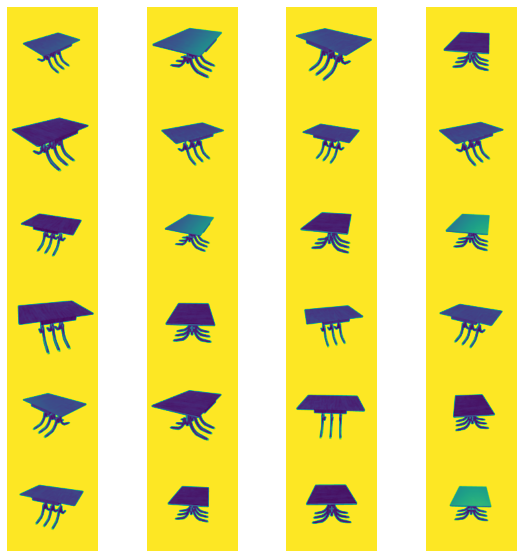

In [24]:
fig, axs = plt.subplots(nrows=6, 
                        ncols=4, 
                        sharex=True, 
                        sharey=True, 
                        figsize=(10,10),
                        gridspec_kw={'wspace': 0, 'hspace':0}
                        )
images = data_file['pixels'][input_num][...]
for ax, im in zip(axs.flatten(), range(24)):
    ax.imshow(images[im,:,:])
    ax.axis('off')
    

### Input Voxels

Look at the voxelized input model. Use the cubify function from PyTorch3D to convert from binvox 3D grid occupancy
to renderable mesh surface. 

In [25]:
voxels_ = data_file['voxels'][input_num][...]
voxels_ = voxels_[np.newaxis,:,:,:,0]
voxels_.shape
voxels = torch.tensor(voxels_,dtype=torch.float64, device=torch.device('cpu'))

In [26]:
voxels;

In [27]:
voxel_mesh = cubify(voxels, thresh=.5, align='topleft')

In [28]:
voxel_mesh.verts_list()[0]

tensor([[-0.5556, -0.3968, -0.2698],
        [-0.5556, -0.3968, -0.2381],
        [-0.5556, -0.3968, -0.2063],
        ...,
        [ 0.5556,  0.4286,  0.7143],
        [ 0.5556,  0.4286,  0.7460],
        [ 0.5556,  0.4286,  0.7778]])

In [75]:
temp_ply_file = output_path + 'notebook_temp.ply'
save_ply(f=temp_ply_file, verts=voxel_mesh.verts_list()[0], faces=voxel_mesh.faces_list()[0])

temp_obj_file = output_path + 'notebook_temp.obj'
save_obj(f=temp_obj_file, verts=voxel_mesh.verts_list()[0], faces=voxel_mesh.faces_list()[0])

In [76]:
os.listdir(output_path);

In [77]:
mesh = pv.read(temp_file)
#z = mesh.points[:, 2]

# Plot using the ITKplotter
pl = pv.PlotterITK()
pl.add_mesh(mesh, smooth_shading=False)
pl.show(True)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [78]:
mesh = load_objs_as_meshes([temp_obj_file], device=device, load_textures=False)
print(mesh.isempty())
print(mesh.verts_list())
print(mesh.num_verts_per_mesh())

tensor(False, device='cuda:0')
[tensor([[-0.5556, -0.3968, -0.2698],
        [-0.5556, -0.3968, -0.2381],
        [-0.5556, -0.3968, -0.2063],
        ...,
        [ 0.5556,  0.4286,  0.7143],
        [ 0.5556,  0.4286,  0.7460],
        [ 0.5556,  0.4286,  0.7778]], device='cuda:0')]
tensor([5798], device='cuda:0')


Create a white texture object and set it as the mesh texture. We have to have a texture to render.

In [99]:
verts_rgb = torch.ones_like(mesh.verts_list()[0])[None]
textures = Textures(verts_rgb=verts_rgb.to(device))
mesh.textures = textures

Set up Camera and Renderer:

In [100]:
shapenet_cam_params_file = git_project_directory + 'data/metadata/rendering_metadata.json' 
with open(shapenet_cam_params_file) as f:
  shapenet_cam_params = json.load(f)

In [141]:
param_num = 8
R, T = look_at_view_transform(
    dist=shapenet_cam_params["distance"][param_num]*5, 
    elev=shapenet_cam_params["elevation"][param_num], 
    azim=shapenet_cam_params["azimuth"][param_num]) 
cameras = FoVPerspectiveCameras(device=device, 
                                R=R, 
                                T=T,
                                fov=shapenet_cam_params["field_of_view"][param_num]
                               )

raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

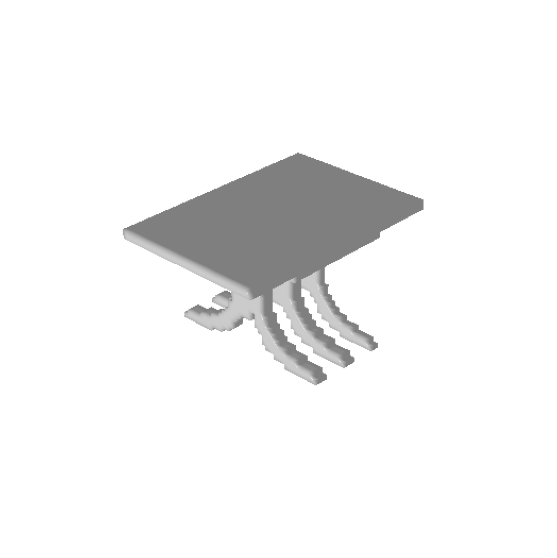

In [118]:
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");

In [137]:
interpolation_dir = '/data/IM-NET-pytorch/data/all_vox256_img/interpol_100_1000/'
files = os.listdir(interpolation_dir)
verts = []
faces = []
verts_rgb = []
for file in files:
    vert, face = load_ply(interpolation_dir + file)
    verts.append(vert.to(device))
    faces.append(face.to(device))
    verts_rgb.append(torch.ones_like(vert).to(device))

textures = Textures(verts_rgb=verts_rgb)
interpol_mesh = Meshes(verts, faces, textures)

In [138]:
print(interpol_mesh.isempty())
print(interpol_mesh.num_verts_per_mesh())

tensor(False, device='cuda:0')
tensor([34304, 32816, 30962, 28268, 27388, 28636, 27868, 28056, 32026, 38050,
        36714, 35694, 63528, 60972, 65310, 68116], device='cuda:0')


In [ ]:
images = renderer(interpol_mesh).cpu().numpy()

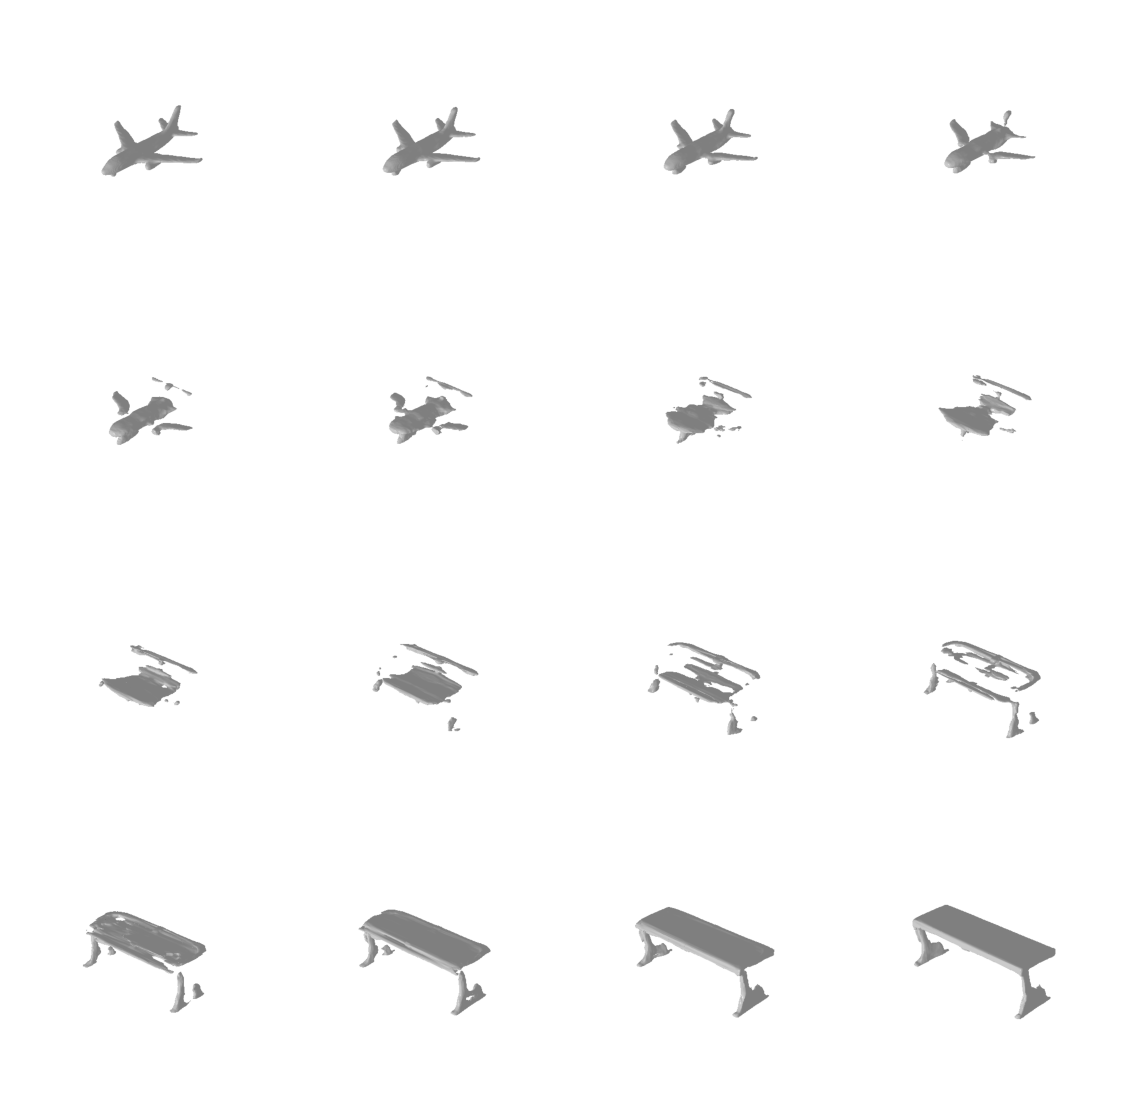

In [144]:
num_images = int(images.shape[0])
rows = int(num_images**.5)
cols = num_images // rows

fig, axs = plt.subplots(nrows=rows, 
                        ncols=cols, 
                        sharex=True, 
                        sharey=True, 
                        figsize=(20,20),
                        gridspec_kw={'wspace': 0, 'hspace':0}
                        )
for ax, im in zip(axs.flatten(), range(24)):
    ax.imshow(images[im,:,:,:3])
    ax.axis('off')